In [1]:
%%html
<style>
.output_subarea.output_text.output_stream.output_stdout > pre {
   width:max-content;
}
.p-Widget.jp-RenderedText.jp-OutputArea-output > pre {
   width:max-content;
}
</style>

In [2]:
def drop_module(dir):
    import sys
    """Drop module from sys modules"""
    if dir in sys.modules:
        del sys.modules[dir]
        print("Libreria actualizada")

# Librerias

In [3]:
from pyspark.sql import SparkSession
from pyspark import SparkConf
import plotly
import numpy as np
import datetime as dt
from matplotlib import pyplot as plt
import pandas as pd
from pyspark.sql import functions as F
spark = SparkSession.builder.appName('sentimental_analysis').getOrCreate()

# Parametros

In [4]:
graficas_path = "graficas/"
start_date_twitter = dt.date(2017, 7, 1)
start_hour_twitter = 11
start_time_twitter_zipped = start_date_twitter
end_date_twitter = dt.date(2019,7,31)
end_hour_twitter = 23

start_date = dt.datetime(2017,7,1,11)
end_date = dt.datetime(2019,8,1,0)
fill_zeros = F.udf(lambda hour: str(hour).zfill(2))
zipped_data = F.concat(F.col("date"),F.lit("-"),fill_zeros(F.col("hour"))).alias("zipped_time")
range_condition = (
                    zipped_data >= dt.datetime.strftime(start_date, "%Y-%m-%d-%H")
                  ) & (
                    zipped_data < dt.datetime.strftime(end_date, "%Y-%m-%d-%H")
                  )


# Cargando datos

In [5]:
tweets_path_master = 'data/twitter_data/'
tweets_path = "data/twitter_data/raw_data/"

In [54]:
tweets_dataframe = spark.read.parquet(tweets_path).where(range_condition)

In [7]:
import re
from pyspark.sql.types import StringType, StructField, StructType, FloatType
drop_module('utils.text_clean')
from utils.text_clean import tweet_cleaning_for_sentiment_analysis
from textblob import TextBlob
clean_text_udf = F.udf(lambda text: tweet_cleaning_for_sentiment_analysis(text), StringType())
schema_sen = StructType([
        StructField('polarity', FloatType()),
        StructField('subjectivity', FloatType())
])
def get_sen(text):
    result = {'polarity':None, 'subjectivity':None}
    try:
        if((text != None )& (text != '') ):
            txt_blob = TextBlob(text)
            result['polarity'] = txt_blob.polarity
            result['subjectivity'] = txt_blob.subjectivity
    except:
        return result
    return result
get_sentiment_analysis = F.udf(get_sen, schema_sen)

In [8]:
tweets_transformed = tweets_dataframe.withColumn('text_clean', clean_text_udf(F.col("text"))
                                                ).withColumn('sentiment', get_sentiment_analysis(F.col('text_clean')))

In [9]:
sentiment_analysis = tweets_transformed.select(
    'date', 'hour', 'id',
    F.col('sentiment.polarity').alias('polarity'),
    F.col('sentiment.subjectivity').alias('subjectivity')
)
#                                         ).groupBy('polarity').count().orderBy(F.col('polarity')
#                                         ).toPandas().plot.bar(x = 'polarity', y='count', figsize=(20, 12))
# plt.show()

In [10]:
sentiment_analysis.write.partitionBy('date').parquet(tweets_path_master+'/sentiment_analysis/')

In [6]:
sentiment_analysis = spark.read.parquet(tweets_path_master+'sentiment_analysis/')


In [10]:
def get_twitter_variables(dataframe, t_hold):
    negative_range = F.col('polarity') < -t_hold
    positive_range = F.col('polarity') > t_hold
    neutral_range = (F.col('polarity') >= -t_hold) &  (F.col('polarity') <= t_hold)
    agg_dataframe = dataframe.groupBy('date','hour').agg(
        F.sum(F.when(negative_range, 1).otherwise(0)).alias('negative_tweets'),
        F.sum(F.when(positive_range, 1).otherwise(0)).alias('positive_tweets'),
        F.sum(F.when(neutral_range, 1).otherwise(0)).alias('neutral_tweets'),
        F.avg(F.col('polarity')).alias('avg_polarity'),
        F.count('*').alias('num_tweets')
    )
    ratios_arr = [
        'date','hour',
        (F.col('negative_tweets')/F.col('num_tweets')).alias('n_ratio_tweets'),
        (F.col('positive_tweets')/F.col('num_tweets')).alias('p_ratio_tweets'),
        (F.col('neutral_tweets')/F.col('num_tweets')).alias('nl_ratio_tweets'),
        (F.col('positive_tweets')/(F.col('positive_tweets')+F.col('negative_tweets'))).alias('pr_no_neutral_tweets'),
        F.col('avg_polarity'),
        F.col('num_tweets')
    ]
    return agg_dataframe.select(*ratios_arr)

In [29]:
sentiment_dataframe = get_twitter_variables(sentiment_analysis, 0.26).toPandas()

In [30]:
joined_dataframe = time_dataframe.merge(sentiment_dataframe, how="left", on=["date", "hour"])
joined_dataframe.interpolate(inplace=True)

In [34]:
list(joined_dataframe.columns)

['date',
 'hour',
 'n_ratio_tweets',
 'p_ratio_tweets',
 'nl_ratio_tweets',
 'pr_no_neutral_tweets',
 'avg_polarity',
 'num_tweets']

In [31]:
joined_dataframe.sort_values(by=["date", "hour"]).to_csv("data/twitter_data/bitcoin_tweets_sentiment.csv", index=False)

In [26]:
datetime_fun = lambda d_h: dt.datetime(d_h[0].year, d_h[0].month, d_h[0].day, d_h[1])
sentiment_dataframe['time'] = np.apply_along_axis(datetime_fun, 1, sentiment_dataframe[["date","hour"]].values) 

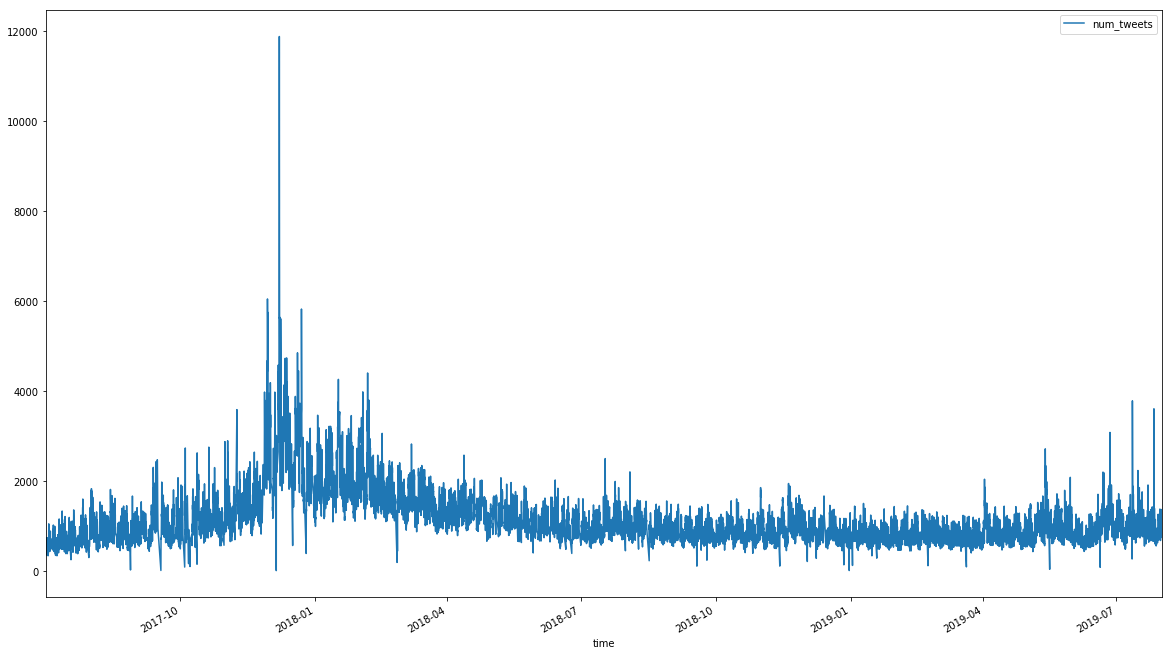

In [28]:
sentiment_dataframe.sort_values(by=["time"]).plot(x='time', y='num_tweets', figsize=(20,12))
plt.show()

In [20]:
joined_dataframe[joined_dataframe['n_ratio_tweets'].isnull()].count()

date                    1468
hour                    1468
n_ratio_tweets             0
p_ratio_tweets             0
nl_ratio_tweets            0
pr_no_neutral_tweets       0
avg_polarity               0
num_tweets                 0
dtype: int64

In [14]:
sentiment_dataframe.orderBy('date', 'hour').toPandas().to_csv('data/twitter_data/bitcoin_tweets_sentiment.csv', index=False)

In [7]:
prices_dataframe = pd.read_csv("data/all_both_cryptocurrency.csv", parse_dates=["date"])
prices_dataframe["date"] = prices_dataframe.date.dt.date
prices_dataframe.sort_values(by=["date", "hour"], ascending=True, inplace=True)
datetime_fun = lambda d_h: dt.datetime(d_h[0].year, d_h[0].month, d_h[0].day, d_h[1])
prices_dataframe['time'] = prices_dataframe[["date","hour"]].apply(datetime_fun, axis=1)

In [52]:
sentiment_pandas['date'].max()

datetime.date(2019, 7, 31)

In [49]:
prices_dataframe

date  hour     close_btc      high_btc       low_btc  volume_btc  \
0      2017-07-01    11   2501.346680   2506.309977   2491.313395  162.346667   
1      2017-07-01    12   2487.340007   2503.810059   2481.366699  160.456668   
2      2017-07-01    13   2449.293294   2487.670003   2444.143311  342.700002   
3      2017-07-01    14   2455.413330   2472.710042   2442.323324  312.586670   
4      2017-07-01    15   2464.006755   2470.943278   2447.030029  226.220001   
5      2017-07-01    16   2459.816650   2466.223307   2446.856689  230.930003   
6      2017-07-01    17   2443.620036   2460.046631   2428.679932  399.703349   
7      2017-07-01    18   2418.383301   2449.740072   2408.033366  625.086670   
8      2017-07-01    19   2431.986654   2434.796712   2401.889974  456.483327   
9      2017-07-01    20   2395.750000   2434.786621   2394.516683  524.376668   
10     2017-07-01    21   2405.576742   2414.333333   2385.003337  633.446655   
11     2017-07-01    22   2412.203369   2418.180013   2386.686686  346.399994   
12     2017-07-01    23   2409.663249   2420.363281   2399.990072  307.380010   
13     2017-07-02     0   2378.830078   2417.013346   2371.250000  453.360006   
14     2017-07-02     1   2396.629964   2408.506592   2370.569987  335.779999   
15     2017-07-02     2   2390.136719   2399.333333   2369.646729  405.299998   
16     2017-07-02     3   2397.286702   2403.920003   2382.413330  284.426671   
17     2017-07-02     4   2397.983317   2401.519938   2383.886719  229.063334   
18     2017-07-02     5   2428.119954   2432.383301   2396.673340  333.750005   
19     2017-07-02     6   2408.070068   2432.546631   2402.043294  182.120000   
20     2017-07-02     7   2428.063314   2431.453369   2405.306722  241.676661   
21     2017-07-02     8   2446.663330   2447.663330   2420.979980  245.700007   
22     2017-07-02     9   2441.223307   2453.993327   2435.143311  285.173335   
23     2017-07-02    10   2425.060059   2445.130046   2420.330078  145.589999   
24     2017-07-02    11   2437.686686   2441.826742   2415.729980  159.623332   
25     2017-07-02    12   2426.256673   2441.780029   2418.119954  129.349998   
26     2017-07-02    13   2422.683350   2435.073405   2414.966634  274.863332   
27     2017-07-02    14   2428.760010   2432.389974   2416.336670  172.889999   
28     2017-07-02    15   2454.286702   2461.223389   2425.603353  358.673340   
29     2017-07-02    16   2461.803304   2472.356608   2450.466634  353.093333   
...           ...   ...           ...           ...           ...         ...   
18223  2019-07-30    18   9645.056966   9666.856771   9626.626628  207.486669   
18224  2019-07-30    19   9605.523438   9669.393555   9503.626628  509.356659   
18225  2019-07-30    20   9541.076497   9625.123372   9528.506510  287.543330   
18226  2019-07-30    21   9586.066732   9594.076823   9519.596680  197.403336   
18227  2019-07-30    22   9578.476562   9649.276693   9560.640299  259.986664   
18228  2019-07-30    23   9592.243164   9609.356445   9571.610026  110.066666   
18229  2019-07-31     0   9712.049805   9717.986979   9573.033203  418.613322   
18230  2019-07-31     1   9708.893229   9736.220052   9665.569987  331.533340   
18231  2019-07-31     2   9683.263346   9713.439779   9668.436849  106.776666   
18232  2019-07-31     3   9683.323242   9692.080078   9638.203125  177.006667   
18233  2019-07-31     4   9682.529948   9690.456706   9653.753581  151.530001   
18234  2019-07-31     5   9710.403320   9782.059896   9681.823242  385.839996   
18235  2019-07-31     6   9771.563151   9788.810221   9704.426432  204.990005   
18236  2019-07-31     7   9737.149740   9830.796875   9729.930013  351.309998   
18237  2019-07-31     8   9762.826823   9783.606445   9733.786458  185.106669   
18238  2019-07-31     9   9768.436849   9772.926758   9730.586589  189.416669   
18239  2019-07-31    10   9778.576823   9795.676432   9753.826823  189.380000   
18240  2019-07-31    11   9765.743164   9783

In [17]:
from dateutil import relativedelta as rd
hours =  (end_date - start_date).days * 24 +  (end_date - start_date).seconds // 3600
hours_list = [start_date + rd.relativedelta(hours=hr)  for hr in range(hours)]
data_hour_list = list(map(lambda el: [el.date(), el.hour], hours_list))
time_dataframe = pd.DataFrame(data_hour_list, columns=["date", "hour"])

In [12]:
tweets_fields = ['n_ratio_tweets','p_ratio_tweets','nl_ratio_tweets','pr_no_neutral_tweets','avg_polarity','num_tweets']
target = 'close_btc'

In [13]:
def abt_full(sentiment_dataframe, prices_dataframe, time_dataframe, t_hold_c):
    sentiment_pandas = sentiment_dataframe.toPandas()
    joined_dataframe = time_dataframe.merge(sentiment_pandas, how="left", on=["date", "hour"])
    full_joined_dataframe = joined_dataframe.merge(prices_dataframe, how="left", on=["date", "hour"])
    full_joined_dataframe.sort_values(by=["date", "hour"], ascending=True, inplace=True)
    abt_raw = full_joined_dataframe[['date', 'hour']+tweets_fields+[target]].copy()
    abt_raw['next'] = abt_raw[target].shift(-1)
    change_expression =( abt_raw['next']/abt_raw[target]) - 1
    abt_raw['target'] = np.where(np.abs(change_expression)<t_hold_c,1, np.where((change_expression)>=t_hold_c,2,0))
    return abt_raw.drop(['date', 'hour',target,'next'], axis=1).values

In [18]:
abt_array.groupby('target').count()

AttributeError: 'numpy.ndarray' object has no attribute 'groupby'

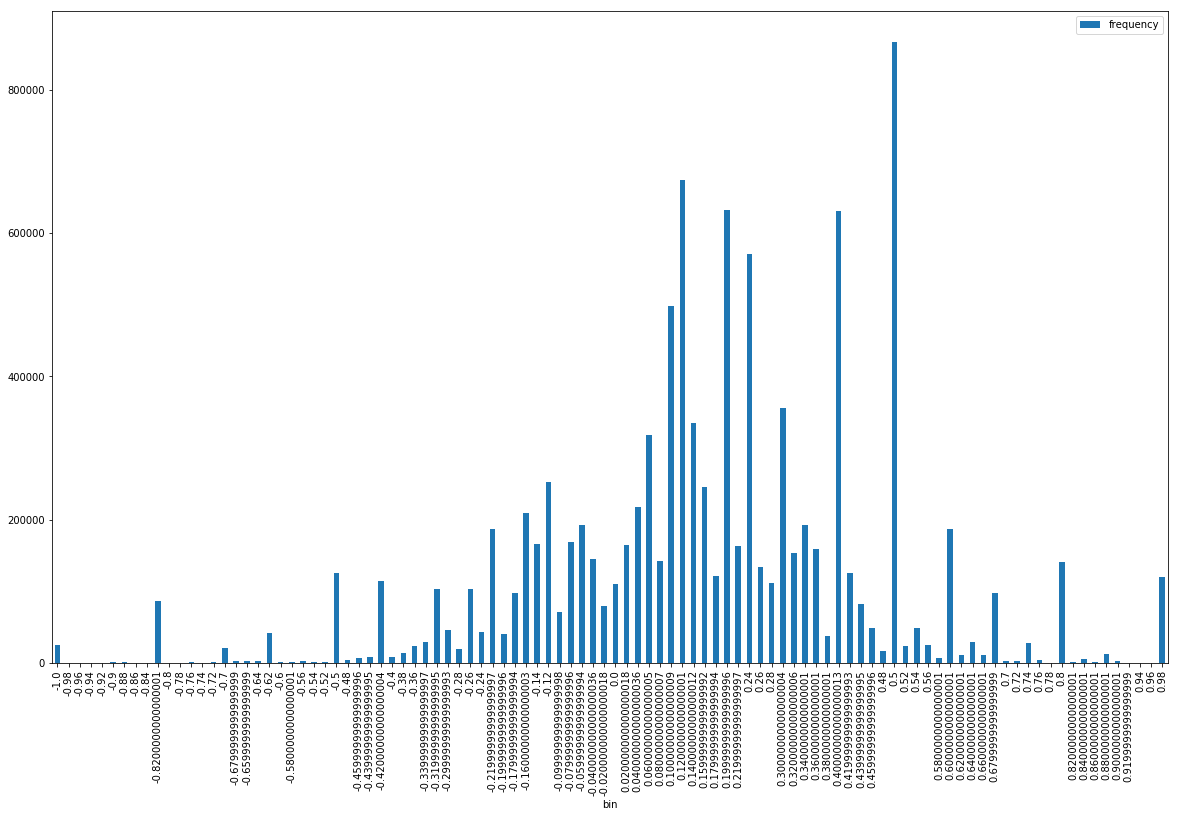

In [9]:
gre_histogram = sentiment_analysis.where(F.col('polarity')!=0).select('polarity').rdd.flatMap(lambda x: x).histogram(100)

# Loading the Computed Histogram into a Pandas Dataframe for plotting
pd.DataFrame(
    list(zip(*gre_histogram)), 
    columns=['bin', 'frequency']
).set_index(
    'bin'
).plot(kind='bar', figsize=(20, 12));
plt.show()

n_ratio_tweets  p_ratio_tweets  nl_ratio_tweets  pr_no_neutral_tweets
target                                                                       
0                    1               1                1                     1
1                16784           16784            16784                 16784

In [16]:
sentiment_dataframe = get_twitter_variables(sentiment_analysis, 0.25)

In [58]:
tweets_dataframe.where(F.col("id").isin("941095371521978368")).show(truncate=False)

+---------+----------+----+-------+-------+---------+---+---------------------------+------------------+--------+------------------------------------------------------+-------+--------+--------------------------------------------------------------------------------------------------------------------------------------------------+-------------------+--------+
|author_id|date      |hour|minutes|seconds|favorites|geo|hashtags                   |id                |mentions|permalink                                             |replies|retweets|text                                                                                                                                              |urls               |username|
+---------+----------+----+-------+-------+---------+---+---------------------------+------------------+--------+------------------------------------------------------+-------+--------+-------------------------------------------------------------------------------------------

In [9]:
core_pd = sentiment_analysis.where((F.col('polarity').isNotNull())&(F.col('polarity') !=0)).select('polarity').toPandas()

KeyboardInterrupt: 

In [60]:
sentiment_analysis.groupBy("polarity").count().orderBy('polarity').toPandas().plot.bar(x='polarity', y='count', figsize=(20,12))
plt.show()

KeyboardInterrupt: 

In [53]:
sentiment_analysis.show()

+----+------------------+----------+------------+----------+
|hour|                id|  polarity|subjectivity|      date|
+----+------------------+----------+------------+----------+
|  23|941095371521978368|       0.2|         0.2|2017-12-13|
|  23|941095370490368001|      0.35|        0.35|2017-12-13|
|  23|941095370238644224|       0.0|         0.0|2017-12-13|
|  23|941095354061152256|       0.0|         0.0|2017-12-13|
|  23|941095350747705345|       0.0|         0.0|2017-12-13|
|  23|941095336591814656|0.44444445|  0.44444445|2017-12-13|
|  23|941095317482758146|       0.0|         0.0|2017-12-13|
|  23|941095288768475136|       0.0|         0.0|2017-12-13|
|  23|941095273064837120|  -0.34375|    -0.34375|2017-12-13|
|  23|941095266903474177|       0.0|         0.0|2017-12-13|
|  23|941095254836502528|     0.175|       0.175|2017-12-13|
|  23|941095225082220545|       0.0|         0.0|2017-12-13|
|  23|941095222838251520|       0.0|         0.0|2017-12-13|
|  23|941095218203340801

In [17]:
abt_array = abt_full(sentiment_dataframe, prices_dataframe, time_dataframe,0.26)

In [24]:
full_set = abt_array[:14602]
y = full_set[:,-1]
x = full_set[:,:-1]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
model = XGBClassifier(n_estimators=5, max_depth=10)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=5, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot as plt

In [25]:
model.predict(X_test)

array([1., 0., 1., ..., 1., 0., 2.])

In [205]:
sentiment_dataframe.orderBy('date','hour').toPandas().to_csv('twitter_data/sentiment_analysis.csv', index=False)

In [46]:
results = []
models_array = []
for t_hold in np.arange(0,001.71,0.05):
    sentiment_dataframe = get_twitter_variables(sentiment_analysis, t_hold)
    abt_array = abt_full(sentiment_dataframe, prices_dataframe, time_dataframe,0.002)
    full_set = abt_array[:14602]
    y = full_set[:,-1]
    x = full_set[:,:-1]
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
    model = XGBClassifier(n_estimators=500, max_depth=10)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results.append({"accuracy":accuracy_score(y_pred, y_test), 't_hold':t_hold})
    models_array.append(model)
    print('.', end='')
    


....................

ValueError: unknown is not supported

In [52]:
results

[{'accuracy': 0.4074412234649623, 't_hold': 0.0},
 {'accuracy': 0.3999086966446017, 't_hold': 0.05},
 {'accuracy': 0.38758274366582973, 't_hold': 0.1},
 {'accuracy': 0.40036521342159326, 't_hold': 0.15000000000000002},
 {'accuracy': 0.38963706916229174, 't_hold': 0.2},
 {'accuracy': 0.3821045423419311, 't_hold': 0.25},
 {'accuracy': 0.3848436430038804, 't_hold': 0.30000000000000004},
 {'accuracy': 0.3834740926729057, 't_hold': 0.35000000000000003},
 {'accuracy': 0.3868979685003424, 't_hold': 0.4},
 {'accuracy': 0.39260442821273683, 't_hold': 0.45},
 {'accuracy': 0.39237616982424106, 't_hold': 0.5},
 {'accuracy': 0.3878110020543255, 't_hold': 0.55},
 {'accuracy': 0.3805067336224606, 't_hold': 0.6000000000000001},
 {'accuracy': 0.3830175758959142, 't_hold': 0.65},
 {'accuracy': 0.3916913946587537, 't_hold': 0.7000000000000001},
 {'accuracy': 0.37731111618351976, 't_hold': 0.75},
 {'accuracy': 0.3916913946587537, 't_hold': 0.8},
 {'accuracy': 0.39557178726318193, 't_hold': 0.8500000000000

In [45]:
results

[{'accuracy': 0.4074412234649623, 't_hold': 0.0},
 {'accuracy': 0.3999086966446017, 't_hold': 0.05},
 {'accuracy': 0.38758274366582973, 't_hold': 0.1},
 {'accuracy': 0.40036521342159326, 't_hold': 0.15000000000000002},
 {'accuracy': 0.38963706916229174, 't_hold': 0.2},
 {'accuracy': 0.3821045423419311, 't_hold': 0.25},
 {'accuracy': 0.3848436430038804, 't_hold': 0.30000000000000004},
 {'accuracy': 0.3834740926729057, 't_hold': 0.35000000000000003},
 {'accuracy': 0.3868979685003424, 't_hold': 0.4},
 {'accuracy': 0.39260442821273683, 't_hold': 0.45},
 {'accuracy': 0.39237616982424106, 't_hold': 0.5},
 {'accuracy': 0.3878110020543255, 't_hold': 0.55},
 {'accuracy': 0.3805067336224606, 't_hold': 0.6000000000000001},
 {'accuracy': 0.3830175758959142, 't_hold': 0.65},
 {'accuracy': 0.3916913946587537, 't_hold': 0.7000000000000001}]

In [32]:
results

[{'accuracy': 0.41702807578178497, 't_hold': 0.01},
 {'accuracy': 0.40926729057292854, 't_hold': 0.060000000000000005},
 {'accuracy': 0.39191965304724946, 't_hold': 0.11},
 {'accuracy': 0.4058434147454919, 't_hold': 0.16000000000000003},
 {'accuracy': 0.3996804382561059, 't_hold': 0.21000000000000002},
 {'accuracy': 0.3980826295366355, 't_hold': 0.26},
 {'accuracy': 0.4058434147454919, 't_hold': 0.31000000000000005},
 {'accuracy': 0.40219128052955944, 't_hold': 0.36000000000000004},
 {'accuracy': 0.4115498744578863, 't_hold': 0.41000000000000003},
 {'accuracy': 0.4085825154074412, 't_hold': 0.46},
 {'accuracy': 0.4081259986304497, 't_hold': 0.51},
 {'accuracy': 0.3999086966446017, 't_hold': 0.56},
 {'accuracy': 0.412919424788861, 't_hold': 0.6100000000000001},
 {'accuracy': 0.4010499885870806, 't_hold': 0.66}]

In [93]:
import numpy as np

In [104]:
abt_array = abt_raw.drop(['date', 'hour',target,'next'], axis=1).values

In [106]:
num_hours_h =24

In [112]:
y = full_set[:,-1]
x = full_set[:,:-1]

In [116]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [130]:
X_train[0]

array([4.72689076e-02, 2.13235294e-01, 7.39495798e-01, 8.18548387e-01,
       7.13676289e-02, 9.52000000e+02])

In [34]:
tweets_fields

['n_ratio_tweets',
 'p_ratio_tweets',
 'nl_ratio_tweets',
 'pr_no_neutral_tweets',
 'avg_polarity',
 'num_tweets']

In [43]:
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot as plt
# load data
# fit model no training data
# plot feature importance
fig  = plt.Figure(figsize=(20,12))
plt.rcParams.update({'font.size': 22})
plt.rcParams["figure.figsize"] = (20, 12)
plot_importance(models_array[9])
plt.show()

In [149]:
tweets_fields

['n_ratio_tweets', 'p_ratio_tweets', 'nl_ratio_tweets', 'pr_no_neutral_tweets']

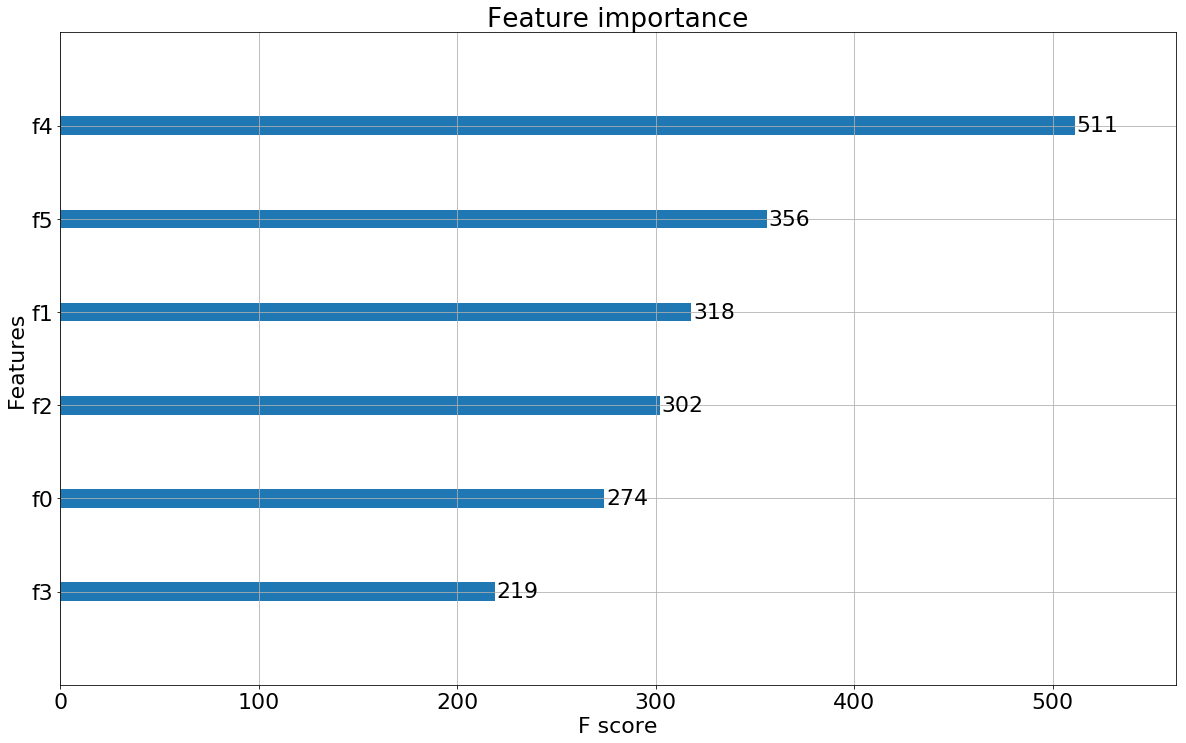

In [182]:
fig  = plt.Figure(figsize=(20,12))
plt.rcParams.update({'font.size': 22})
plt.rcParams["figure.figsize"] = (20, 12)
plot_importance(model)
plt.show()

In [131]:
y_pred = model.predict(X_test)

In [134]:
from sklearn.metrics import accuracy_score

In [135]:
accuracy_score(y_pred, y_test)

0.821730198584798

In [133]:
y_test

array([1., 1., 1., ..., 1., 1., 0.])

In [117]:
from xgboost import XGBClassifier

In [108]:
!pip install xgboost

     |████████████████████████████████| 142.8MB 5.8MB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.


In [103]:
abt_raw

date  hour  n_ratio_tweets  p_ratio_tweets  nl_ratio_tweets  \
0      2017-07-01    11        0.068230        0.228145         0.703625   
1      2017-07-01    12        0.039308        0.257862         0.702830   
2      2017-07-01    13        0.075581        0.302326         0.622093   
3      2017-07-01    14        0.040000        0.234667         0.725333   
4      2017-07-01    15        0.044140        0.258752         0.697108   
5      2017-07-01    16        0.033283        0.216339         0.750378   
6      2017-07-01    17        0.031776        0.233645         0.734579   
7      2017-07-01    18        0.032258        0.244482         0.723260   
8      2017-07-01    19        0.047059        0.208403         0.744538   
9      2017-07-01    20        0.092352        0.246753         0.660895   
10     2017-07-01    21        0.046713        0.228374         0.724913   
11     2017-07-01    22        0.067327        0.279208         0.653465   
12     2017-07-01    23        0.078652        0.207865         0.713483   
13     2017-07-02     0        0.043121        0.266940         0.689938   
14     2017-07-02     1        0.067470        0.216867         0.715663   
15     2017-07-02     2        0.070093        0.250000         0.679907   
16     2017-07-02     3        0.033241        0.232687         0.734072   
17     2017-07-02     4        0.035533        0.276650         0.687817   
18     2017-07-02     5        0.026005        0.193853         0.780142   
19     2017-07-02     6        0.059242        0.222749         0.718009   
20     2017-07-02     7        0.040816        0.201814         0.757370   
21     2017-07-02     8        0.048544        0.308252         0.643204   
22     2017-07-02     9        0.028736        0.298851         0.672414   
23     2017-07-02    10        0.040519        0.188006         0.771475   
24     2017-07-02    11        0.055769        0.242308         0.701923   
25     2017-07-02    12        0.036242        0.296644         0.667114   
26     2017-07-02    13        0.062914        0.213576         0.723510   
27     2017-07-02    14        0.048622        0.215559         0.735818   
28     2017-07-02    15        0.095076        0.188455         0.716469   
29     2017-07-02    16        0.092879        0.247678         0.659443   
...           ...   ...             ...             ...              ...   
18223  2019-07-30    18        0.052003        0.282182         0.665814   
18224  2019-07-30    19        0.049323        0.240812         0.709865   
18225  2019-07-30    20        0.047767        0.267913         0.684320   
18226  2019-07-30    21        0.051535        0.244518         0.703947   
18227  2019-07-30    22        0.032847        0.293187         0.673966   
18228  2019-07-30    23        0.052566        0.277847         0.669587   
18229  2019-07-31     0        0.033766        0.246753         0.719481   
18230  2019-07-31     1        0.031873        0.265604         0.702523   
18231  2019-07-31     2        0.030178        0.272977         0.696845   
18232  2019-07-31     3        0.058394        0.294891         0.646715   
18233  2019-07-31     4        0.116667        0.290278         0.593056   
18234  2019-07-31     5        0.058442        0.297403         0.644156   
18235  2019-07-31     6        0.045638        0.311409         0.642953   
18236  2019-07-31     7        0.054545        0.265072         0.680383   
18237  2019-07-31     8        0.044041        0.269430         0.686528   
18238  2019-07-31     9        0.065702        0.276169         0.658129   
18239  2019-07-31    10        0.037534        0.339589         0.622878   
18240  2019-07-31    11        0.034816        0.310445         0.653772   
18241  2019-07-31    12        0.054404        0.278066         0.667530   
18242  2019-07-31    13        0.056511        0.248976         0.694513   
18243  2019-07-31    14        0.053130        0.262009      

In [100]:
abt_raw.groupby('target').count()

date   hour  n_ratio_tweets  p_ratio_tweets  nl_ratio_tweets  \
target                                                                  
0        1539   1539            1408            1408             1408   
1       15142  15142           13930           13930            13930   
2        1572   1572            1447            1447             1447   

        pr_no_neutral_tweets  avg_polarity  num_tweets  close_btc   next  
target                                                                    
0                       1408          1408        1408       1539   1538  
1                      13930         13930       13930      15142  15142  
2                       1447          1447        1447       1572   1572

In [ ]:
end_trainning = 14602

In [47]:
# joined_dataframe.values[]

In [6]:
tweets_path = "data/twitter_data/raw_data/"
tweets_dataframe = spark.read.parquet(tweets_path)

In [6]:
day_count_dataframe = tweets_dataframe.groupBy("date").count().orderBy(F.col("date")).toPandas()

In [11]:
plotly.offline.plot({
"data": [
    plotly.graph_objs.Bar( x=day_count_dataframe["date"], y=day_count_dataframe["count"])
],
'layout': {'title': 'Volumen de tweets en periodo 2016-01 a 2019-08'}
}, filename=graficas_path+"/tweets_historic_histogram.html")

'graficas//tweets_historic_histogram.html'

In [7]:
checker = tweets_dataframe.where(range_condition).groupBy("date","hour").count().toPandas()

In [8]:
checker['time'] = checker[["date","hour"]].apply(datetime_fun, axis=1)

In [9]:
print(checker['time'].min())
print(checker['time'].max())

2017-07-01 11:00:00
2019-07-31 23:00:00


In [20]:
prices_dataframe['time'].min()

Timestamp('2017-07-01 11:00:00')

In [24]:
prices_dataframe['time'].max()

Timestamp('2019-07-31 23:00:00')

In [ ]:
time_dataframe

In [40]:
joined_dataframe.sort_values(by=['date', 'time'])

date  hour  count                time
0  2017-07-01    11  469.0 2017-07-01 11:00:00
1  2017-07-01    12  636.0 2017-07-01 12:00:00
2  2017-07-01    13  688.0 2017-07-01 13:00:00
3  2017-07-01    14  750.0 2017-07-01 14:00:00
4  2017-07-01    15  657.0 2017-07-01 15:00:00

In [15]:
joined_dataframe[joined_dataframe['count'].isnull()].count()

date     1468
hour     1468
count       0
time        0
dtype: int64

In [16]:
time_dataframe.count(
)

date    18253
hour    18253
dtype: int64

61.166666666666664

In [28]:
joined_dataframe[joined_dataframe['count'].isnull()].groupby("hour").count().sort_values('date')

date  count  time
hour                   
23      21      0     0
22      25      0     0
21      28      0     0
20      32      0     0
19      39      0     0
18      41      0     0
17      46      0     0
16      52      0     0
15      53      0     0
14      56      0     0
13      59      0     0
12      60      0     0
11      64      0     0
10      69      0     0
9       71      0     0
8       73      0     0
7       76      0     0
6       78      0     0
5       81      0     0
4       82      0     0
3       87      0     0
2       90      0     0
1       91      0     0
0       94      0     0

In [23]:
missings_dates = joined_dataframe[joined_dataframe['count'].isnull()].groupby("date").count().sort_values('date')

In [27]:
missings_dates[missings_dates['hour'] == 24].count()*21

hour     441
count    441
time     441
dtype: int64

In [14]:
from matplotlib import pyplot as plt
joined_dataframe[joined_dataframe['count'].isnull()].sort_values(by=['date', 'time']).plot.bar(x='time', y=1, figsize=(20,12))
plt.show()